In [14]:
import numpy as np
import pandas as pd
from datetime import datetime
from binance.client import Client
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi':100})

In [15]:
size = np.inf

In [16]:
client = Client()

symbol = 'BTCUSDT'
interval = Client.KLINE_INTERVAL_1HOUR
start_str = '1 Jul, 2023'
end_str = datetime.now().strftime('%d %b, %Y')

print(f"Fetching Bitcoin hourly data from {start_str} to {end_str}")
data = client.get_historical_klines(
    symbol=symbol,
    interval=interval,
    start_str=start_str,
    end_str=end_str
)

klines_data = pd.DataFrame(data, columns=[
    'timestamp',
    'open',
    'high',
    'low',
    'close',
    'volume',
    'close_time',
    'quote_asset_volume',
    'number_of_trades',
    'taker_buy_base_volume',
    'taker_buy_quote_volume',
    'ignore'
])

klines_data['timestamp'] = pd.to_datetime(klines_data['timestamp'], unit='ms')

price_columns = ['open', 'high', 'low', 'close']
for col in price_columns:
    klines_data[col] = klines_data[col].astype(float)

df = klines_data[['timestamp', 'close']].copy()
df.columns = ['ds', 'y']

date_range = pd.date_range(start=df['ds'].min(), end=df['ds'].max(), freq='H')
print(f"Expected hours: {len(date_range)}, Actual hours: {len(df)}")

missing_hours = set(date_range) - set(df['ds'])
if len(missing_hours) > 0:
    print(f"Found {len(missing_hours)} missing hours. Reindexing and interpolating...")
    df = df.set_index('ds').reindex(date_range)
    df.index.name = 'ds'
    df['y'] = df['y'].interpolate(method='linear')
    df = df.reset_index()
else:
    print("No missing hours detected.")


nan_count = df['y'].isnull().sum()
if nan_count > 0:
    print(f"Warning: {nan_count} NaN values remain after interpolation")

Fetching Bitcoin hourly data from 1 Jul, 2023 to 12 Jul, 2025
Expected hours: 17809, Actual hours: 17809
No missing hours detected.


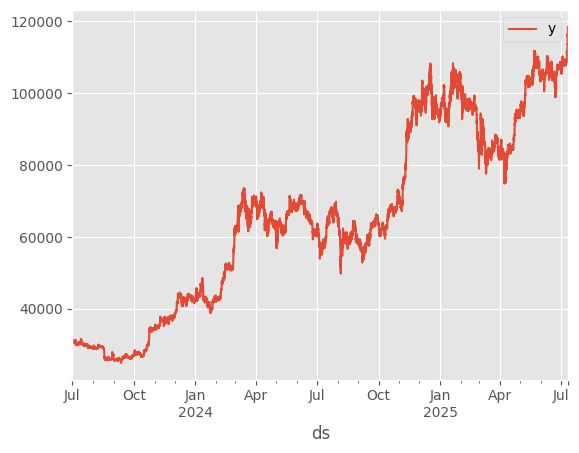

In [17]:
df.plot('ds','y')
plt.show()

In [18]:
df.to_csv(f'{symbol}_{str(interval)}_{str(size)}.csv', index=False)